# Part A Size reduction of imaging cytometry images

In [29]:
import os, sys
import cv2
import tqdm
import skimage as ski
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure
from skimage import filters
from skimage import morphology
from scipy import stats
from adjustText import adjust_text

In [2]:
print(sys.path)

['c:\\Users\\asus\\Desktop\\EPFL\\Course\\2023 Fall\\Mechanobiology\\Project\\Project_2\\PartA', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\python36.zip', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\DLLs', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm', '', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib\\site-packages', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib\\site-packages\\win32', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib\\site-packages\\win32\\lib', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib\\site-packages\\Pythonwin', 'c:\\Users\\asus\\anaconda3\\envs\\MechanoBioIm\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\asus\\.ipython']


In [6]:
FOLDER = os.getcwd()
FILES = os.listdir(FOLDER)
# remove .ipynb files from list
FILES = [f for f in FILES if f.endswith('.tif') or f.endswith('.avi')]
print(FILES)

['CellA_noDoxycycline.avi', 'CellA_noDoxycycline.tif', 'CellA_noDoxycycline_s1.tif', 'CellA_noDoxycycline_test.tif', 'img_selected.tif']


**Convert the Part A files into .tif files, and place them in the same folder with the .ipynb file.**

In [7]:
# read in images
img = ski.io.imread(os.path.join(FOLDER, FILES[1]))
print(img.shape)

(356953, 256, 128)


Given that processing large image files is impossible for computers with limited memory and the fact that the task is simply to detect the presence of cells, we downsampled the image from 256 x 128 to 32 x 16.

In [8]:
# reshape to smaller size
img_resized = np.zeros((img.shape[0], 32, 16))
for i in tqdm.tqdm(range(img.shape[0])):
    img_resized[i] = cv2.resize(img[i], (16, 32), interpolation=cv2.INTER_LINEAR)

  0%|          | 725/356953 [00:00<00:49, 7249.92it/s]

100%|██████████| 356953/356953 [01:56<00:00, 3064.13it/s]


The raw image stack was removed from the memory after downsampling to save memory.

In [9]:
# delete img to save memory
del img

Then we apply a processing pipeline to detect the presence of cells in the downsampled image. The following steps are taken:

- Backgound subtraction: 100 random frames are used to calculate the background image (median) and subtracted from the time stack. The intensity profile of the subtracted image would be shifted to center at 0.
- Variance thresholding: the variance of each frame is calculated and a threshold is set to remove frames with low variance. High variances are presumed to be caused by the presence of cells.

In [12]:
class rtfc_resize:
    def __init__(self, img_stack, int_thres):
        self.img_stack = img_stack
        self.img_stack_sub = np.zeros(img_stack.shape)
        self.img_var = np.zeros(img_stack.shape[0])
        self.int_thres = int_thres
        
    def rsz(self):
        # take a better background
        # randomly take 100 frames from the img_stack and compute the median
        img_median = np.median(self.img_stack[np.random.choice(self.img_stack.shape[0], 100, replace=False)], axis=0)
        # subtract the img_median from the img_stack
        # img_stack is a 3D array, img_median is a 2D array
        # subtraction is done in the 2,3 dimension of img_stack
        self.img_stack_sub = self.img_stack - img_median
        # center each frame around 0
        self.img_stack_sub = self.img_stack_sub - np.mean(self.img_stack_sub, axis=(1,2))[:, np.newaxis, np.newaxis]
        # loop through each frame and perform segmentation
        self.img_var = np.var(self.img_stack_sub, axis=(1,2))
        crop_inds = np.where(self.img_var > self.int_thres)
        
        return crop_inds[0]

A threshold of 2.5 was used based on exploratory analysis of the data.

In [13]:
rresize = rtfc_resize(img_resized, 2.5)
crop_inds = rresize.rsz() # crop_inds is a list of indices of frames that are not empty frames

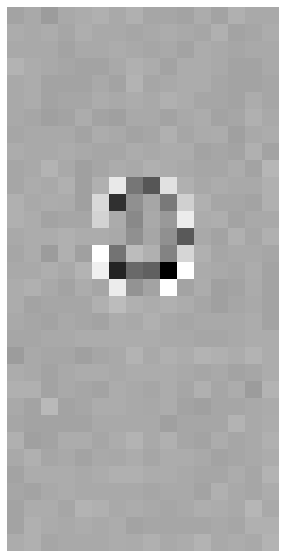

In [14]:
plt.figure(figsize=(5, 10))
plt.imshow(rresize.img_stack_sub[14], cmap='gray')
# hide the axis
plt.axis('off')
plt.show()

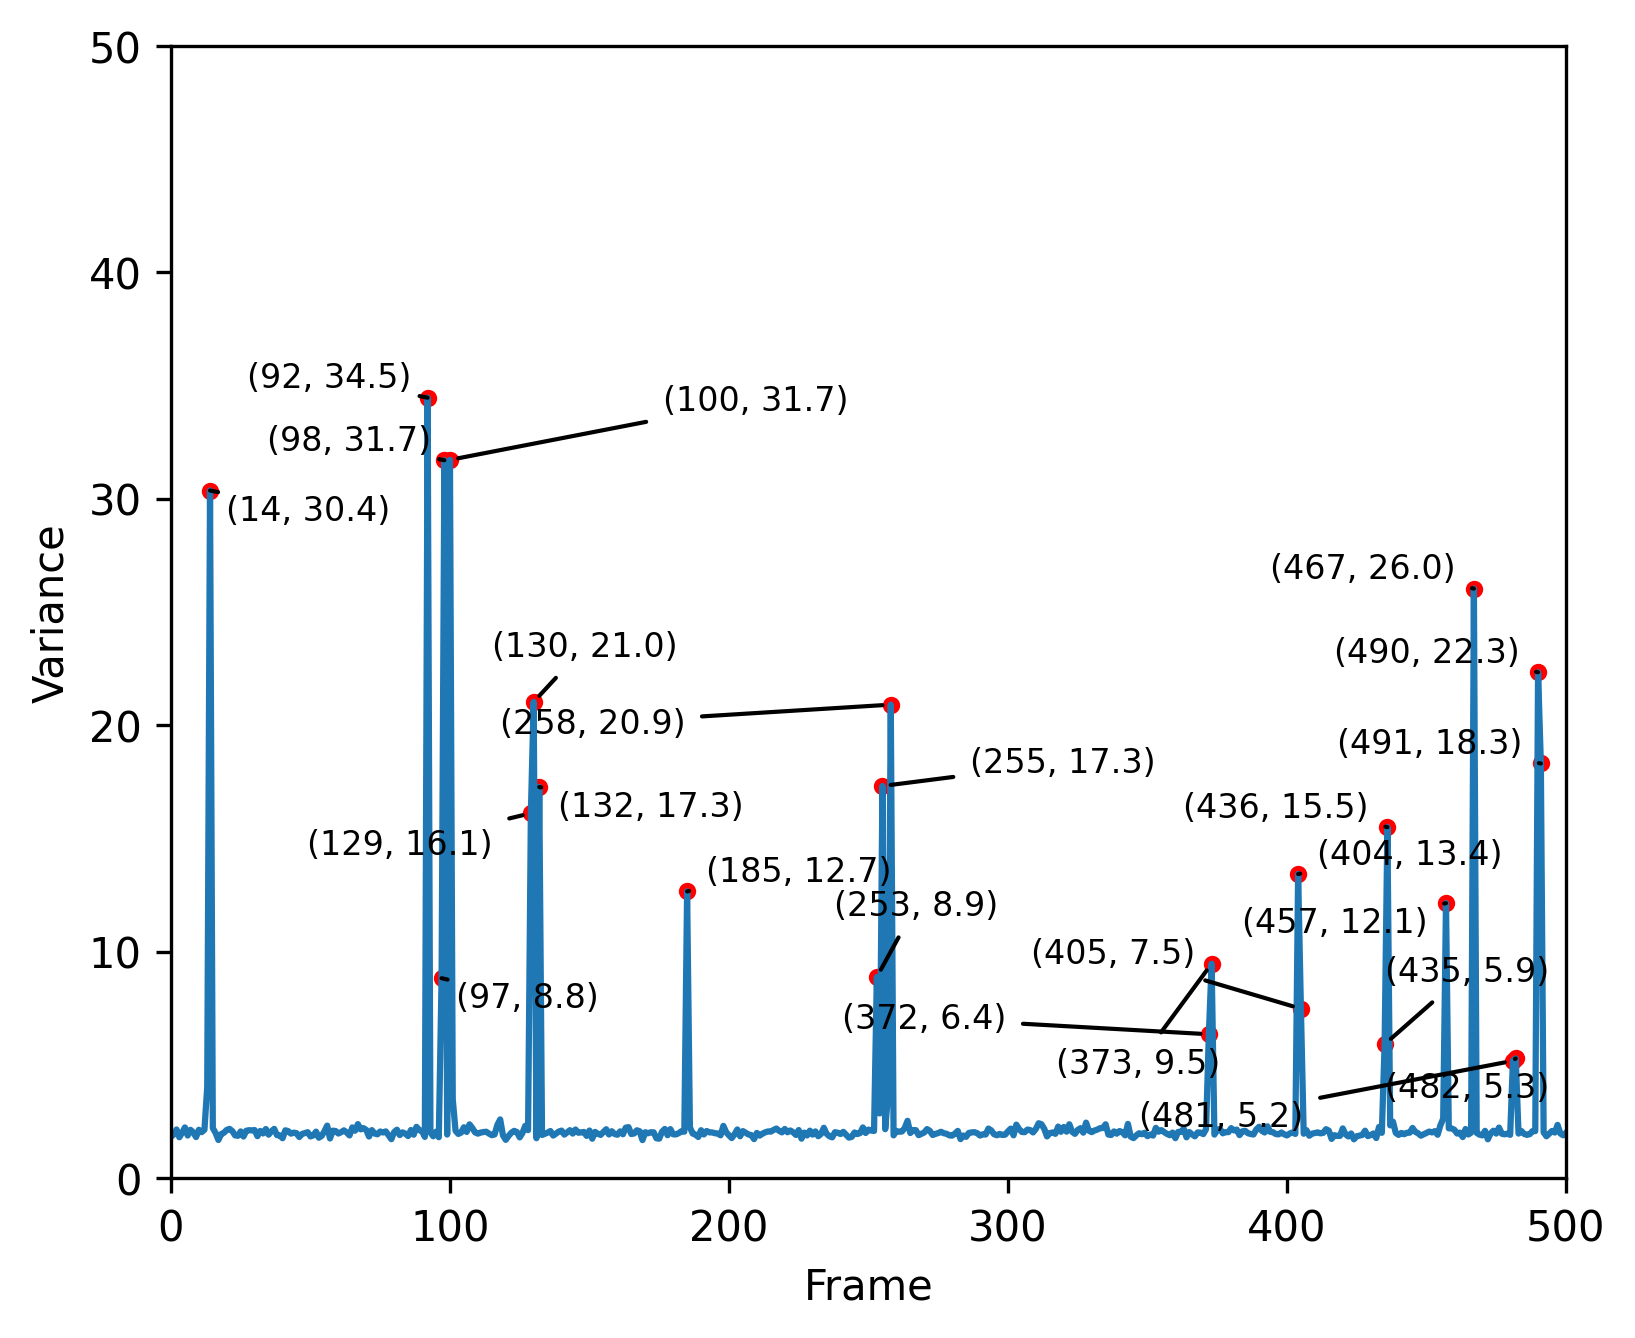

In [51]:
xl = 500

plt.figure(figsize=(6, 5), dpi = 300)
plt.plot(rresize.img_var)
plt.xlim(0, xl)
plt.ylim(0, 50)
plt.xlabel('Frame')
plt.ylabel('Variance')

# Label data points with value > 2.5 and x between 0 and 1000
threshold = 5
indices_above_threshold = np.where((rresize.img_var > threshold) & (np.arange(len(rresize.img_var)) < xl))[0]
values_above_threshold = rresize.img_var[indices_above_threshold]

plt.scatter(indices_above_threshold, values_above_threshold, c='r', s=10)

# Add text labels beside the data points
texts = []
offset = 0
for i, (x, y) in enumerate(zip(indices_above_threshold, values_above_threshold)):
    texts.append(plt.text(x, y+offset, f'({int(x)}, {y:.1f})', color='k', fontsize=8, ha='left', va='top'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(1, 1))

plt.show()

To obtain the final result, we selectively read in non-empty frames and save it as a .tif file.

In [96]:
# read in the raw stack again and duplicate the selected frames in crop_inds
cap = cv2.VideoCapture(os.path.join(FOLDER, FILES[0]))

img_selected = []

for ind in crop_inds:
    cap.set(cv2.CAP_PROP_POS_FRAMES, ind)
    ret, frame = cap.read()
    
    if ret:
        if ind % 10000 == 0:
            print(ind)
        img_selected.append(frame)
        
# convert to numpy array (8-bit)
img_selected = np.array(img_selected, dtype=np.uint8)

130000
200000


The final frame number is 27252, the compressed ratio is 356953/27252 = 13.1. 

In [97]:
print(img_selected.shape)

(27252, 256, 128, 3)


In [99]:
# save as tif
ski.io.imsave(os.path.join(FOLDER, 'img_selected.tif'), img_selected)